# _Capstone Project 1: In-Depth Analysis & Machine Learning_

### Step 1: Getting Everything Ready

In [2]:
# import initial modules
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

In [3]:
# import data 
# dataframe for linear/ridge/huber regression
df = pd.read_csv('data/df_all.csv')

# dataframe for RandomForest
df_rf = pd.read_csv('data/df_all.csv')

In [4]:
# dataframe that sets cut-off based on PER (i.e. player played more than 58 games)
df_threshold = pd.read_csv('data/df_threshold.csv')

In [5]:
df.head(3)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Year
0,Alex Abrines,SG,24,OKC,75,8,1134,5.0,12.7,0.395,3.7,9.7,0.380,1.4,3.1,0.443,1.7,2.0,0.848,1.1,3.9,5.0,1.2,1.7,0.4,1.1,5.4,15.4,116.0,110.0,9.0,0.567,0.759,0.158,2.5,8.9,5.6,3.4,1.7,0.6,7.4,12.7,1.3,1.0,2.2,0.094,-0.5,-1.7,-2.2,-0.1,2018
1,Quincy Acy,PF,27,BRK,70,8,1359,4.6,13.0,0.356,3.6,10.4,0.349,1.0,2.6,0.384,1.8,2.1,0.817,1.4,7.8,9.2,2.0,1.2,1.0,2.1,5.3,14.7,99.0,110.0,8.2,0.525,0.800,0.164,3.1,17.1,10.0,6.0,1.2,1.6,13.3,14.4,-0.1,1.1,1.0,0.036,-2.0,-0.2,-2.2,-0.1,2018
2,Steven Adams,C,24,OKC,76,76,2487,8.9,14.2,0.629,0.0,0.0,0.000,8.9,14.2,0.631,3.2,5.7,0.559,7.7,6.0,13.7,1.8,1.8,1.6,2.6,4.3,21.1,125.0,107.0,20.6,0.630,0.003,0.402,16.6,13.9,15.3,5.5,1.8,2.8,13.3,16.7,6.7,3.0,9.7,0.187,2.2,1.1,3.3,3.3,2018


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4759 entries, 0 to 4758
Data columns (total 51 columns):
Player    4759 non-null object
Pos       4759 non-null object
Age       4759 non-null int64
Tm        4759 non-null object
G         4759 non-null int64
GS        4759 non-null int64
MP        4759 non-null int64
FG        4759 non-null float64
FGA       4759 non-null float64
FG%       4759 non-null float64
3P        4759 non-null float64
3PA       4759 non-null float64
3P%       4759 non-null float64
2P        4759 non-null float64
2PA       4759 non-null float64
2P%       4759 non-null float64
FT        4759 non-null float64
FTA       4759 non-null float64
FT%       4759 non-null float64
ORB       4759 non-null float64
DRB       4759 non-null float64
TRB       4759 non-null float64
AST       4759 non-null float64
STL       4759 non-null float64
BLK       4759 non-null float64
TOV       4759 non-null float64
PF        4759 non-null float64
PTS       4759 non-null float64
ORtg    

In [7]:
# change position, team, and year columns to categorical variables
df[['Pos', 'Tm', 'Year']] = df[['Pos', 'Tm', 'Year']].astype('category')
df_rf[['Pos', 'Tm', 'Year']] = df_rf[['Pos', 'Tm', 'Year']].astype('category')
df_threshold[['Pos', 'Tm', 'Year']] = df_threshold[['Pos', 'Tm', 'Year']].astype('category')

In [8]:
# one-hot encode the data for random forest model using pandas get_dummies
df_rf = pd.get_dummies(df, columns = ['Pos', 'Tm', 'Year'])

In [9]:
df_rf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4759 entries, 0 to 4758
Columns: 106 entries, Player to Year_2018
dtypes: float64(43), int64(4), object(1), uint8(58)
memory usage: 2.0+ MB


In [10]:
# create function that creates array of features and target variable, and returns list of features
# if data set for random forest model, it will only drop Player and WS/48 columns
def convert_features(df, random_forest=True):
    # labels are the values we want to predict
    y = np.array(df['WS/48'])
    
    # remove the labels from the features
    # axis 1 refers to the columns
    if random_forest == True:
        X = df.drop(['Player','WS/48'], axis = 1)
    else:
        X = df.drop(['Player', 'Pos', 'Age', 'Tm', 'OWS', 'DWS', 'WS', 'WS/48', 'Year'], axis = 1)
    
    # saving feature names for later use
    feature_list = list(X.columns)
    
    # convert to np array
    X = np.array(X)
    
    return X, y, feature_list

In [11]:
# scale the data to be between -1 and 1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# function that scales the data and then splits it into train and test set
def scale_then_split(X, y):
    
    # scale the feature data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
    
    return X_train, X_test, y_train, y_test

## _Linear Regression: An Overview_

For this project we are trying to determine a player's `WS/48`, i.e. how many 'wins' he contributes for every 48 minutes he plays. While statistics like total points, rebounds and assists are all important statistics when evaluating any given player, but there is something that trumps all other statistics in basketball (and pretty much all sports): winning. 

The statistics mentioned above only describe a particular segment of that player's contribution to his team. Luckily though this is where `WS/48` comes into play. I'm going to admit up front that it is not perfect. However, it's like the saying: "All models are wrong, but some are useful". In this case `WS/48` is a useful 'model' in bringing together a players offensive and defensive statistics into a single number that allows us to see his level of contribution towards a team winning. 

With this being said, I want to recap quickly what we've done so far up to this point for this project.

1. Pulled Per Possession and Advanced statistics from [basketball-reference.com](https://www.basketball-reference.com/) for the past ten seasons (__not including the 2018-2019 season__)
2. Cleaned up raw data into usable format
3. Performed Exploratory Data Analysis of features of the clean data set

Now we are on the fourth and final step: use machine learning to create a model that is able to approximately predict a player's `WS/48` statistic. 

How are we going to to this? Two words: linear regression. Or at least that's where we'll begin, with `sklearn`'s `LinearRegression` algorithm. 

Simply put, linear regression attempts to model the relationship between a dependent variable and one or more independent variables. If you are using one independent variable, i.e. a one-to-one relationship between the independent and dependent variable, it is called `simple linear regression`. You are not limited to just one though; you can use more than one independent variable, which is called `multiple linear regression`. In summary:

- Simple = 1 independent variable
- Multiple = 2+ independent variables

Now without further ado, let's dive in!

In [12]:
# create array of features and target variable for regression model
X, y, features = convert_features(df, random_forest=False)

In [13]:
# scale then split data
X_train, X_test, y_train, y_test = scale_then_split(X, y)

In [14]:
print('Regression Training Features Shape:', X_train.shape)
print('Regression Training Labels Shape:', y_train.shape)
print('Regression Testing Features Shape:', X_test.shape)
print('Regression Testing Labels Shape:', y_test.shape)

Regression Training Features Shape: (3331, 42)
Regression Training Labels Shape: (3331,)
Regression Testing Features Shape: (1428, 42)
Regression Testing Labels Shape: (1428,)


In [15]:
# Import LinearRegression
from sklearn.linear_model import LinearRegression

# Create the regressor: lr
lr = LinearRegression()

# Fit the model to the data
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [16]:
from sklearn.metrics import mean_squared_error

# Predict on the hold out set and compute metrics
y_pred = lr.predict(X_test)
r2 = lr.score(X_test, y_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [17]:
print("Linear Regression R squared: {}".format(r2))
print("Linear Regression RMSE: {}".format(rmse))

Linear Regression R squared: 0.9750975020909806
Linear Regression RMSE: 0.017308202201025726


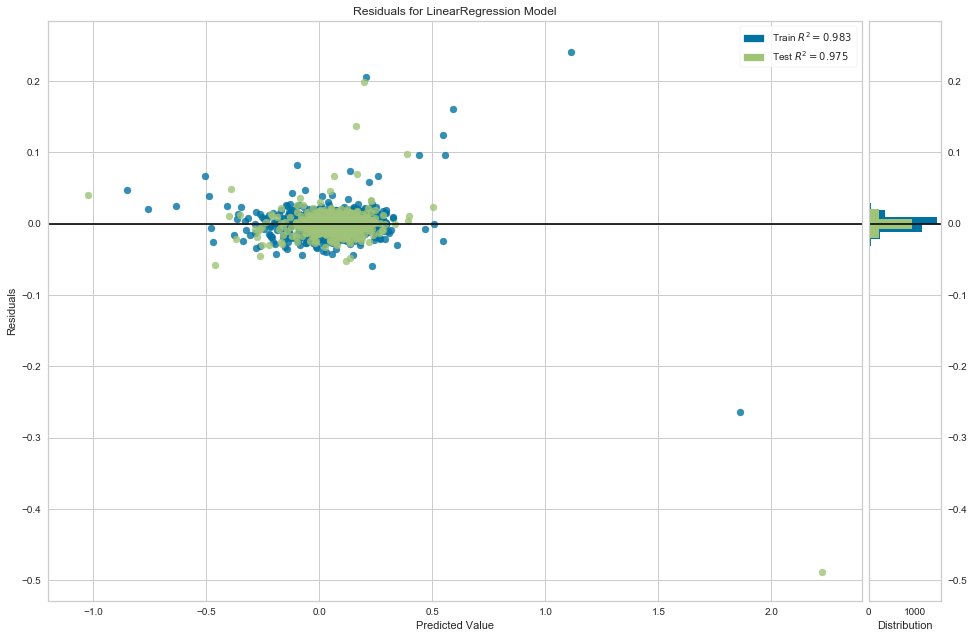

In [18]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(lr, size=(1152, 768), alpha = 0.8)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof();                # Draw/show/poof the data

# _ASSESSMENT: MULTIPLE LINEAR REGRESSION_

So the performance of the model looks pretty amazing! The first statistic, the R squared, basically indicates how close the data is to the fitted regression line. The scale for this number is between 0 and 1.0, with 0 indicating that the model does not explain any of the variability of the response variable (it would basically just be a random assortment of points) and 1 indicating a 'perfect' model in that the model explains all of the variability of the response variable. With our R^2 statistic being ~0.96, this model looks nearly perfect! 

Next, we'll take a look at the RMSE, or root mean square error. This metric also indicates how close the observed data points are to the model's predicted values and is extremely useful in that it is presented in the same units as the response variable i.e. `WS/48`. So our RMSE is ~0.0177 which tells us that on average our predictions were this far off from the observed value.

Lastly, let's look at the residual plot. For the most part it looks good; the resiudals (i.e. the difference in the predicted value and observed value) are not systematically high or low and appear to be centered on zero. Also, the histograms to the right look approximately normally distributed, which is assumed in OLS regression. There appears to be a few outliers, particularly two that severely underestimated `WS/48` which is somewhat concerning and definitely worth looking into. Overall though, this is an impressive start. 

Looks like we got ourselves a model then, right? __WRONG__. 

But before I go further I want to create the same model as before but this time with the `statsmodels` module, which is way better than `sklearn` in regards to statistical data exploration and tests.

In [19]:
import statsmodels.api as sm

X_stats = X # convert to numpy array
X_stats = sm.add_constant(X) # with statsmodels an intercept is not included by default so we need to add one

model = sm.OLS(y, X).fit() # fit ordinary least squares model 
predictions = model.predict(X) # predict values from fitted model

print_model = model.summary() 
print(print_model) # return a summary of the regression results

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     9884.
Date:                Thu, 02 May 2019   Prob (F-statistic):               0.00
Time:                        13:29:44   Log-Likelihood:                 13826.
No. Observations:                4759   AIC:                        -2.757e+04
Df Residuals:                    4717   BIC:                        -2.730e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          9.037e-05   2.11e-05      4.288      0.0

# _Interpretation of `statsmodels` result_

Using the same features as the model we created with `sklearn`, we were able to create a model that had an R squared of 0.989, which was slightly better (albeit we did not split the data into train/test sets, a big no-no). 

However, when we scroll to the bottom we see under `Warnings` a message talking about a condition number being large, indicating the possibility of strong multicollinearity. What does this mean? 

While I won't go to deeply into exactly what the condition number is (as it is a little above my mental pay-grade and involves the use of matrices and derivatives) but from a high level it is a measure of how sensitve a function is to changes or errors in input. For linear regression specifically, it is used as a diagnostic for multicollinearity.

Now this model has a high condition number which indicates multicollinearity, but what exactly does multicollinearity mean? 

To start off, collinearity means there is an association between _two_ explanatory (independent) variables, which means that two of the features we're using have a relationship between each other. Now, multicollinearity is when two or more explanatory variables (i.e. features) in a multiple regression model are highly linearly related. [1](https://en.wikipedia.org/wiki/Multicollinearity)

Going back to our `statsmodels` example, we can see from the features that this makes total sense. A quick example is in regards to `G` (games played) and `GS` (games started); if a player plays in more games, there is probably going to be a greater liklihood that he is going to have started in more games. In other words, these two variables have a relationship! Another example to drive home the point would be in all the shooting percentages -- `FG%`, `3P%`, `2P%`, `FT%` -- as they all depend on the number of makes and attempts which are also in the feature set! 

Hopefully you can see a trend with regards to our feature set and multicollinearity. With basketball statistics, and the relatedness that a lot of them have with each other, I wasn't surprised when this happened. 

Additionally, let's take a look at the `P>|t|` column above. This column represents the `p-values` that tests the null hypothesis that the coefficient of that particular variable (i.e. feature) has no effect on the relationship. Generally a threshold of 0.05 is set, with a number below this representing the case that we reject the null hypothesis of no effect in favor of the alternative which is that this coefficient does have an effect on the response. 

What is slightly confusing however is that there are some variables, like `FG` and `PTS`, that indicated a pretty signficant relationship during our exploratory data analysis (via scatter plots) but have high p-values (i.e. we cannot reject the null hypothesis that they have no effect). My hypothesis is that the high complexity (i.e. high # of total features) of the model is leading to 'noise' crowding out the relationship. 

At this point we've poked quite a few holes in this model but where do we go from here?

The logical next step would seem to point towards feature selection, which is a very important concept in machine learning and involves selecting the most relevant variables for use in predicting the response variable, which in our case is `WS/48`. 

No we could begin by doing something along the lines of examing R squared value of each of the variables and `WS/48`, then use a subset of variables to create a model. However, this can be tedious and there is not guarantee that we won't encounter multicollinearity again. 

Which is what brings me to a new concept, called regularization...

(__PS__ - Below is a profile report that I generated via the `pandas-profiling` [library](https://github.com/pandas-profiling/pandas-profiling), which provides a wealth of information regarding each column. It will be presented in an interactive HTML report and also indicates where some variables are correlated with each other.)

In [23]:
# generate HTML report file via pandas-profiling of data set
import pandas_profiling

profile = pandas_profiling.ProfileReport(df)
profile.to_file(outputfile='NBA_stats_profile.html')

First I want to begin by showing a (relatively) simple chart:
    
![Model Complexity](model_complexity.png)

### What is this showing us?

Three words: bias-variance tradeoff. 

Bias is associated with the features of the model, in that the more features you include the less likely you are to miss the relevant relations between the features and response variable. For the most part, the more features you include, the better you are able to capture the relationship and the less 'biased' the model becomes.

Variance has to do with sensitivity to 'noise', which are random disturbances in the data. Overfitting can happen when an algorithm begins to model this random noise versus the features we input into it. 

As you can see the more complex we make a model, we decrease the bias which is a good thing. However, there is a trade-off and that is we can begin to increase the variance expnentially, which is not a good thing. This is what has happened in our case; we've made two models that have low bias but high variance. 

Some may be wondering though, why is this whole bias-variance tradoff a big deal to begin with? It has to do with generalizing to unseen data.

When we gather data, we are essentially gathering a sample. For example, in our case we have gathered data from the past 10 NBA seasons yet the NBA's inaugural season was in 1946! So out of approximately 72 seasons we have data for only 10 of those. What we are hoping for though is to create a model with this sample that we could also use on data from the 1977 season as well, and would still do a good job. In other words, we want to be able to generalize it which means we are can confidently apply it to any NBA season (given we have the statistics from that particular season). 

At this point, I would not feel comfortable doing that. There might be certain patterns and/or 'noise' within this particular dataset that the model is including and if we were to test it on a new data set (which doesn't have this particular noise) it would probably fail. And why would you want to make a model that performs well in only particular context?

That being said, we want to decrease the bias (i.e. model complexity) of our model in hopes that we can also decrease the variance and in turn minimize the total error. 

### Regularization, and Lasso or Ridge?

What we want to do is address the issue of overfitting and regularization is one way to do this. It does this by adding penalties to the original OLS equation, as the model complexity increases. 

The two examples we'll look at -- Lasso and Ridge -- add the penalty in slightly different ways.

Lasso Regression (Least Absolute Shrinkage and Selection Operator) adds a penalty equivalent to the absolute value of the magnitude of the coefficients. Now what is the significance of a large coefficient (i.e. how much the dependent variable is expected to increase when that independent variable increases by one)?

It means that that particular feature is a good predictor for the outcome however, when it becomes too large the algortihm will begin to model the intricate relations (i.e. the 'noise') which causes overfitting. 

# TO BE CONTINUED (Write up on why you're choosing Ridge Regression)

# _Ridge Regression: Baseline Model_

In [39]:
# import module
from sklearn.linear_model import Ridge

In [40]:
# Create a ridge regressor: ridge
base_model = Ridge(random_state = 1)

In [41]:
# fit the model on training data
base_model.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=1, solver='auto', tol=0.001)

In [42]:
# Predict on the hold out set and compute metrics
y_pred = base_model.predict(X_test)
r2 = base_model.score(X_test, y_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Ridge Regression R squared: {}".format(r2))
print("Ridge Regression RMSE: {}".format(rmse))

Ridge Regression R squared: 0.9728818975884694
Ridge Regression RMSE: 0.018061763537866683


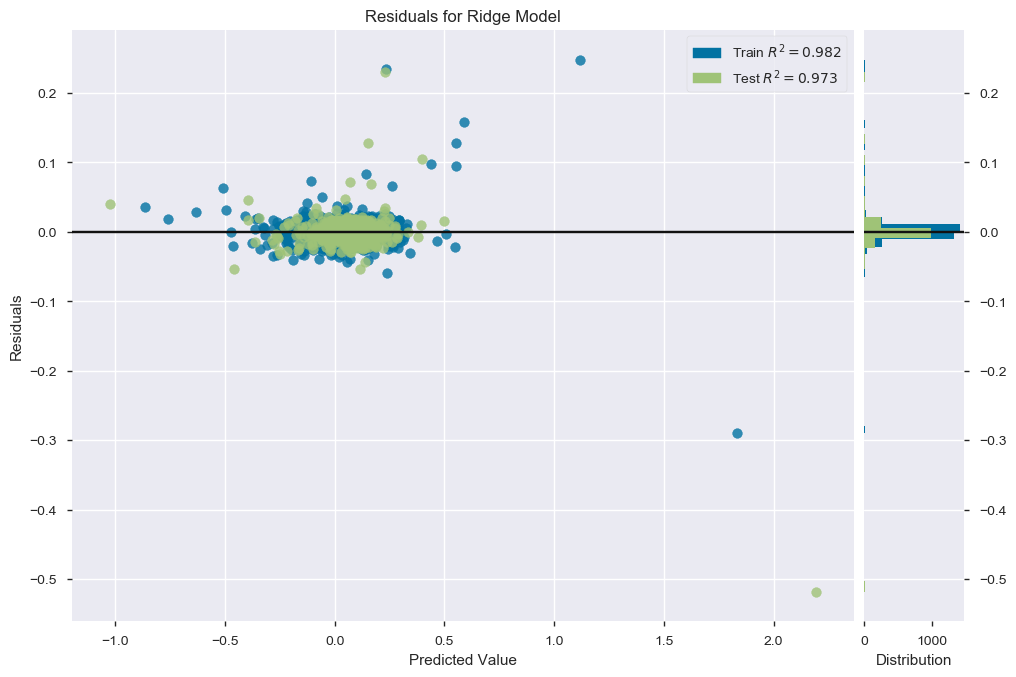

In [43]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(base_model, size=(1152, 768), alpha = 0.8)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof();  

# _Ridge Regression: Cross-Validated Model_

In [44]:
# import module
from sklearn.linear_model import RidgeCV

In [45]:
# Create a ridge regressor
ridge_cv = RidgeCV(cv = 5)

In [46]:
# fit the model on training data
ridge_cv.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [47]:
# Predict on the hold out set and compute metrics
y_pred_ridge_cv = ridge_cv.predict(X_test)
r2_ridge_cv = ridge_cv.score(X_test, y_test)
rmse_ridge_cv = np.sqrt(mean_squared_error(y_test, y_pred_ridge_cv))

print("Ridge Regression R squared: {}".format(r2_ridge_cv))
print("Ridge Regression RMSE: {}".format(rmse_ridge_cv))

Ridge Regression R squared: 0.9748608729800231
Ridge Regression RMSE: 0.017390240980457702


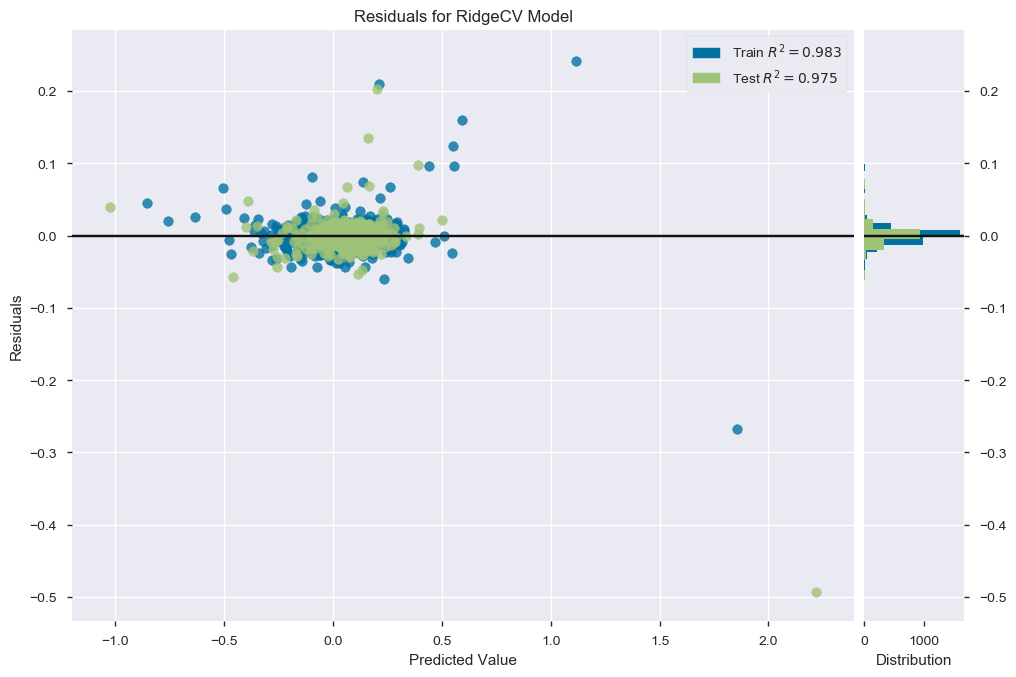

In [48]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(ridge_cv, size=(1152, 768), alpha = 0.8)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof();  

# _Ridge Regression: Tuning Alpha_

In [57]:
# function to plot cross-validated R squared scores and standard error for varying different 
# alphas

# import necessary modules
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure(figsize = (12,10))
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show();
    

In [64]:
ridge = Ridge(random_state=1)

# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-10, 10, 200)
ridge_scores = []
ridge_scores_std = []

In [65]:
# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha
    
    # Perform 5-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, X_train, y_train, cv=5)
    
    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

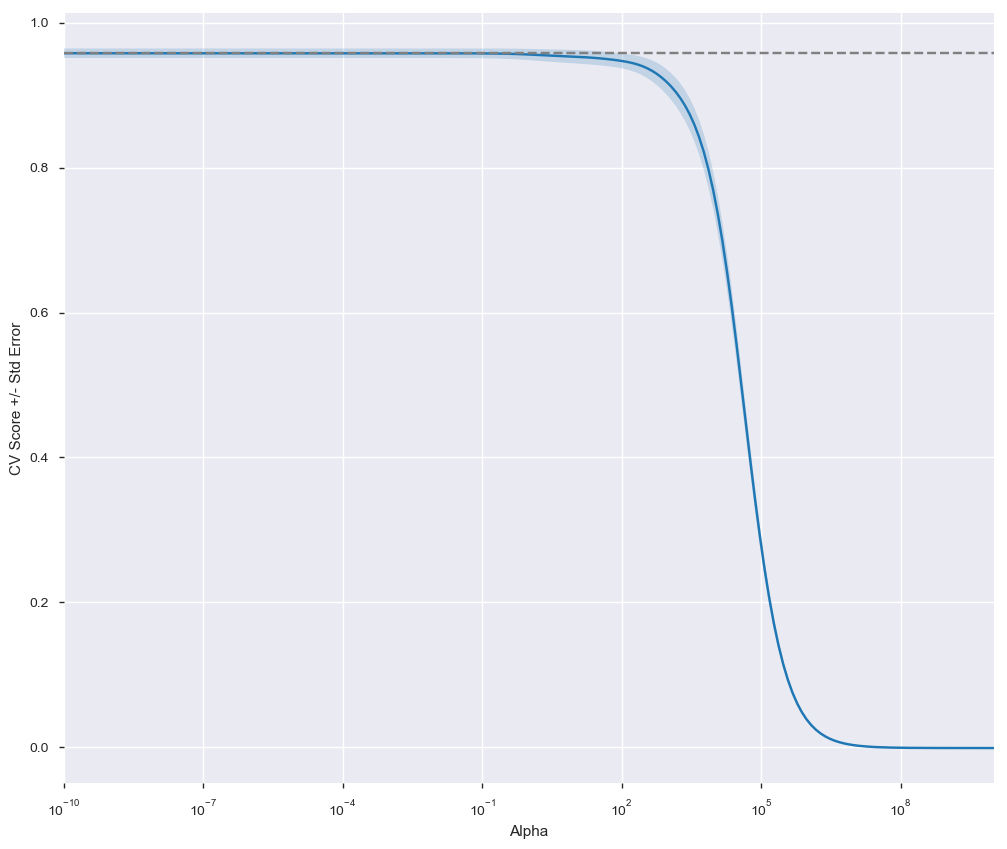

In [66]:
# Display the plot
display_plot(ridge_scores, ridge_scores_std)

In [67]:
# Setup the hyperparameter grid
alpha_space = np.logspace(-10, 10, 200)
param_grid = {'alpha': alpha_space}

In [68]:
# import GridSearchCV
from sklearn.model_selection import GridSearchCV

ridge_regressor = GridSearchCV(ridge, param_grid=param_grid, scoring='neg_mean_squared_error',
                              cv = 5)
# fit model
ridge_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=10000000000.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=1, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([1.00000e-10, 1.26038e-10, ..., 7.93410e+09, 1.00000e+10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [79]:
print(ridge_regressor.best_params_['alpha'])
print(ridge_regressor.best_score_)

1e-10
-0.00040432290795273566


In [81]:
# Create a ridge regressor with best alpha from GridSearch
ridge_alpha = Ridge(alpha = ridge_regressor.best_params_['alpha'], random_state = 1)

# fit the model on training data
ridge_alpha.fit(X_train, y_train)

# Predict on the hold out set and compute metrics
y_pred_ridge_alpha = ridge_alpha.predict(X_test)
r2_ridge_alpha = ridge_alpha.score(X_test, y_test)
rmse_ridge_alpha = np.sqrt(mean_squared_error(y_test, y_pred_ridge_alpha))

print("Ridge Regression R squared: {}".format(r2_ridge_alpha))
print("Ridge Regression RMSE: {}".format(rmse_ridge_alpha))

Ridge Regression R squared: 0.9750975020907563
Ridge Regression RMSE: 0.017308202201103632


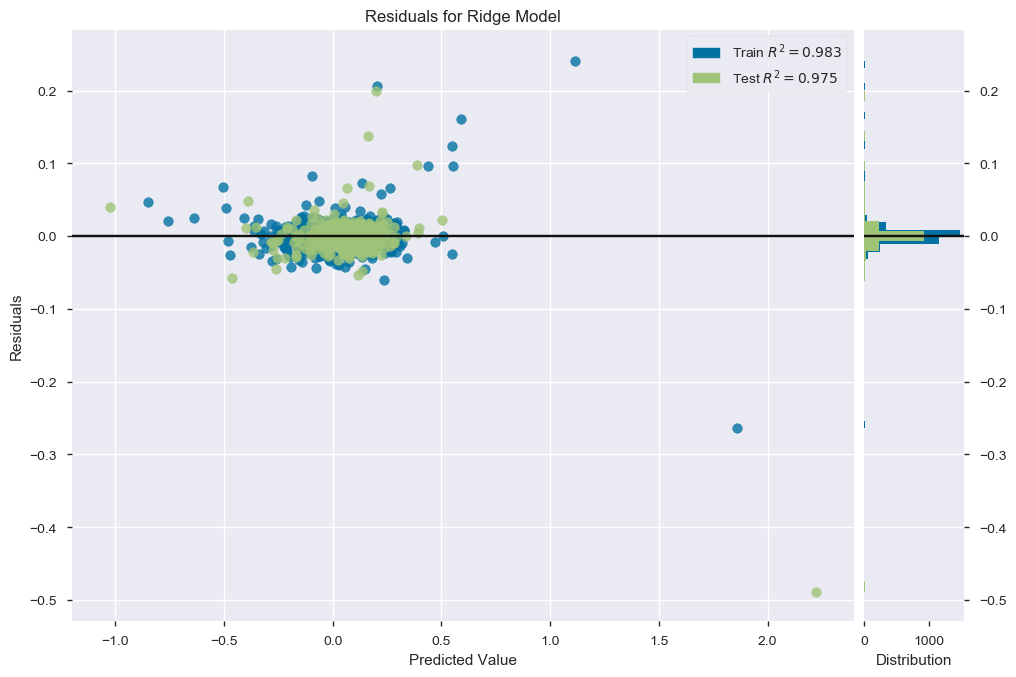

In [82]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(ridge_alpha, size=(1152, 768), alpha = 0.8)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof();  